# Model Building Notebook

Model was intitially built in google colab and incorporates lessons learned from different walkthroughs and examples

In [28]:
!pip install -q -U keras-tuner

In [29]:
import numpy as np                               # linear algebra
import pandas as pd                              # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re                                        # to handle regular expressions
from string import punctuation                   # to extract the puntuation symbols
import nltk
from nltk.tokenize import word_tokenize          # to divide strings into tokens
from nltk.stem import WordNetLemmatizer          # to lemmatize the tokens
from nltk.corpus import stopwords                # to remove the stopwords 

import random                                    # for generating (pseudo-)random numbers
import matplotlib.pyplot as plt                  # to plot some visualizations

import tensorflow as tf            
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization
from kerastuner.tuners import Hyperband
import kerastuner as kt

In [ ]:
print("{}: modules loaded in {} loading data".format(starti, starti-overallstart))
code_dir = os.getcwd()
print("Current working directory: {0}".format(code_dir))
parent_dir = os.getcwd()
print("C working directory: {0}".format(code_dir))
data_dir = os.path.join(parent_dir,"Data")
tweet_dir = os.path.join(parent_dir,"TweetMap")
directory = os.path.join(data_dir,'splits')
dsa= os.path.dirname(code_dir)

In [30]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
code_dir = os.getcwd()
parent_dir = os.path.dirname(code_dir)
print(parent_dir)
# Set up folders
labled_data_folder  =  os.path.join(parent_dir,"Data/crisis_datasets_benchmarks/all_data_en")
initial_filtering_folder = os.path.join(parent_dir,"Data/crisis_datasets_benchmarks/initial_filtering")

In [ ]:
filtered  = pd.read_table(os.path.join
                       (initial_filtering_folder,
                                    "crisis_consolidated_informativeness_filtered_lang.tsv"))
informative_df = filtered[filtered["lang"] == 'en']

In [ ]:
informative_df.class_label =  informative_df.class_label.astype('category')
informative_df.class_label
informative_df["class_label_cat"] = informative_df.class_label.cat.codes
informative_df = informative_df.groupby(by=['class_label_cat'])
test = informative_df.sample(frac = 0.25, random_state = 42)
test.to_csv(os.path.join(parent_dir,"Data","InformativenessTest_Processed.csv)")
informative_df = filtered[filtered["lang"] == 'en']
train = informative_df.drop(test.axes[0])
train.to_csv(os.path.join(parent_dir,"Data","InformativenessTrain_Processed.csv)")

In [32]:
train_data = pd.read_csv(os.path.join(directory, 'InformativenessTrain_Processed.csv'))
test_data  = pd.read_csv(os.path.join(directory, 'InformativenessTest_Processed.csv'))

In [33]:
# Text Cleaning Helper Functions 

def clean_text(text):
    '''Make text lowercase, remove links,remove punctuation
    and remove words containing numerals.'''
    text = text.lower()
    #get rid of usernames
    tweet_words = text.strip('\r').split(' ')
    for word in [word for word in tweet_words if '@' in word]:
            
            text = text.replace(word, "")
    #get rid of the re-tweet
    tweet_words = text.strip('\r').split(' ')
    for word in [word for word in tweet_words if 'rt' == word]:
            
            text = text.replace(word, "")
            
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]  ##Notice the use of text.
def concatenate_text(text):
    return ' '.join(text)

In [34]:
# Applying the cleaning function to both test, train, and scraped datasets
train_data['text'] = train_data['text'].apply(lambda x: clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x: clean_text(x))
train_data['text'] = train_data['text'].apply(lambda x:word_tokenize(x))
test_data['text'] = test_data['text'].apply(lambda x:word_tokenize(x))
train_data['text'] = train_data['text'].apply(lambda x : remove_stopwords(x))
test_data['text'] = test_data['text'].apply(lambda x : remove_stopwords(x))
train_data['text'] = train_data['text'].apply(lambda x : lemmatize_text(x))
test_data['text'] = test_data['text'].apply(lambda x : lemmatize_text(x))
train_data['text'] = train_data['text'].apply(lambda x : concatenate_text(x))
test_data['text'] = test_data['text'].apply(lambda x : concatenate_text(x))


In [37]:
train_data.to_csv(os.path.join(directory,"train_data.csv"),index = False)
test_data.to_csv(os.path.join(directory,"test_data.csv"),index = False)

In [38]:
# !wget -P /content/drive/MyDrive/Capstone https://nlp.stanford.edu/data/wordvecs/glove.twitter.27B.zip
# !unzip "/content/drive/MyDrive/Capstone/WordVector.zip"  -d "/content/drive/MyDrive/Capstone/WordVector" 

In [40]:
path_to_glove_file = '/content/drive/MyDrive/Capstone/WordVector/WordVector/glove.twitter.27B.200d.txt'
embeddings_index = {}
f = open(path_to_glove_file, 'r', encoding='utf8')
for line in f:
    splitLine = line.split(' ')
    word = splitLine[0]                                  # the first entry is the word
    coefs = np.asarray(splitLine[1:], dtype='float32')   # these are the vectors representing word embeddings
    embeddings_index[word] = coefs
print("Glove data loaded! In total:",len(embeddings_index)," words.")

Glove data loaded! In total: 1193515  words.


In [ ]:
def train_val_split(df, validation_split):
    """
    This function generates the training and validation splits from an input dataframe
    
    Parameters:
        dataframe: pandas dataframe with columns "text" and "target" (binary)
        validation_split: should be between 0.0 and 1.0 and represent the proportion of the dataset to 
        include in the validation split
    
    Returns:
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        train_labels: list of labels (0 or 1) in the training dataset
        val_labels: list of labels (0 or 1) in the validation dataset      
    """
       
    text = df['text'].values.tolist()                         # input text as list
    targets = df['class_label_cat'].values.tolist()                    # targets
    
#   Preparing the training/validation datasets
    
    seed = random.randint(1,50)   # random integer in a range (1, 50)
    rng = np.random.RandomState(seed)
    rng.shuffle(text)
    rng = np.random.RandomState(seed)
    rng.shuffle(targets)

    num_validation_samples = int(validation_split * len(text))

    train_samples = text[:-num_validation_samples]
    val_samples = text[-num_validation_samples:]
    train_labels = targets[:-num_validation_samples]
    val_labels = targets[-num_validation_samples:]
    
    print(f"Total size of the dataset: {df.shape[0]}.")
    print(f"Training dataset: {len(train_samples)}.")
    print(f"Validation dataset: {len(val_samples)}.")
    
    return train_samples, val_samples, train_labels, val_labels
train_samples, val_samples, train_labels, val_labels = train_val_split(train_data, 0.25)

In [ ]:
def test_listerine(df):
    """
    This function generates the test x and y from an input dataframe
    
    Parameters:
        dataframe: pandas dataframe with columns "text" and "class_label_cat" (binary)
        
    
    Returns:
        test_samples: list of strings in the training dataset

        test_labels: list of labels (0 or 1) in the training dataset
    
    """
       
    text = df['text'].values.tolist()                         # input text as list
    targets = df['class_label_cat'].values.tolist()                    # targets
    
#   Preparing the training/validation datasets
    
    seed = random.randint(1,50)   # random integer in a range (1, 50)
    rng = np.random.RandomState(seed)
    rng.shuffle(text)
    rng = np.random.RandomState(seed)
    rng.shuffle(targets)

   

    test_samples = text
   
    test_labels = targets
    
    
    print(f"Total size of the dataset: {df.shape[0]}.")

    
    return test_samples, test_labels
test_samples, test_labels = test_listerine(test_data)

In [ ]:
test_samples[1:5]

In [ ]:
def make_embedding_matrix(train_samples, val_samples, embeddings_index):
    """
    This function computes the embedding matrix that will be used in the embedding layer
    
    Parameters:
        train_samples: list of strings in the training dataset
        val_samples: list of strings in the validation dataset
        embeddings_index: Python dictionary with word embeddings
    
    Returns:
        embedding_matrix: embedding matrix with the dimensions (num_tokens, embedding_dim), 
        where num_tokens is the vocabulary of the input data, 
        and emdebbing_dim is the number of components in the GloVe vectors (can be 50,100,200,300)
        vectorizer: TextVectorization layer      
    """
    
    vectorizer = TextVectorization(max_tokens=55000, output_sequence_length=50)
    text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
    vectorizer.adapt(text_ds)
    
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
      
    num_tokens = len(voc)
    
    hits = 0
    misses = 0

#   creating an embedding matrix
    embedding_dim = len(embeddings_index['the'])
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

#     print("Converted %d words (%d misses)" % (hits, misses))
    print(f"Converted {hits} words ({misses} misses).")

    return embedding_matrix, vectorizer

In [45]:
embedding_matrix, vectorizer = make_embedding_matrix(train_samples, val_samples, embeddings_index)

Converted 32208 words (22792 misses).


In [ ]:
def initialize_nn(embedding_matrix):
    """
    This function initializes Keras model for binary text classification
    
    Parameters:
        embedding matrix with the dimensions (num_tokens, embedding_dim),
         where num_tokens is the vocabulary size of the input data,
          and emdebbing_dim is the number of components in the GloVe vectors
    
    Returns:
        model: Keras model    
    """
    
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                # we are not going to train the embedding vectors
    )
    
#   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(.7)(x)
    x = layers.Bidirectional(layers.LSTM(128,                                        
                                          dropout=.4,
                                          return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32,
                                          dropout=.5))(x)
    x = layers.Dense(128,activation= 'sigmoid')(x)
    x = layers.Dropout(.5)(x)
    preds = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(int_sequences_input, preds)
    
    return model

In [ ]:
# !rm -r "/content/drive/MyDrive/Capstone/loggy3"

In [ ]:
def myparamalam(hp):
    """
    This function initializes Keras model for binary text classification
    
    Parameters:
        embedding matrix with the dimensions (num_tokens, embedding_dim),
         where num_tokens is the vocabulary size of the input data,
          and emdebbing_dim is the number of components in the GloVe vectors
    
    Returns:
        model: Keras model    
    """
    hp_num_nodes = hp.Choice('num_units', values =[16,32,64,128])
    hp_activation = hp.Choice('activator',values=['tanh','sigmoid', 'relu'])
    hp_activation2 = hp.Choice('activator2',values=['tanh','sigmoid', 'relu'])
    HP_DROPOUT_IN = hp.Choice('dropout_in_rate', values=[0.7, 0.8, 0.9])
    HP_DROPOUT = hp.Choice('dropout_rate', values=[0.4, 0.5, 0.6])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2,1e-3,1e-4])
                                 
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                # we are not going to train the embedding vectors
    )


#   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(HP_DROPOUT_IN)(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes,                                        
                                         dropout=HP_DROPOUT,
                                         return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes,
                                         dropout=HP_DROPOUT))(x)
    x = layers.Dense(hp_num_nodes,activation= hp_activation)(x)
    x = layers.Dropout(HP_DROPOUT)(x)
    preds = layers.Dense(1, activation=hp_activation2)(x)
    model = keras.Model(int_sequences_input, preds)

    # print('')
    # print("Training the model...")
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy','binary_accuracy',])
    return model

In [ ]:
## Create Log and Vectorize the samples 
LOG_DIR3 = "/content/drive/MyDrive/Capstone/loggy2"
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))



### tuner 
tuner = Hyperband(
    myparamalam,
    objective='val_binary_accuracy',   
    max_epochs= 1000, 
    directory=LOG_DIR3)

tuner.search_space_summary(extended=False)

tuner.search(x_train, y_train,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             batch_size=64,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
             validation_data=(x_val, y_val))


In [ ]:
def myparamalam2(hp):

    hp_num_nodes = hp.Choice('num_units', values =[16,32,64,128])
    hp_num_nodes2 = hp.Choice('num_units2', values =[16,32,64,128])
    hp_num_nodes3 = hp.Choice('num_units3', values =[16,32,64,128])
    hp_activation = hp.Choice('activator',values=['tanh','sigmoid', 'relu'])
    HP_DROPOUT = hp.Choice('dropout_rate', values=[0.4, 0.5])
    HP_DROPOUT2 = hp.Choice('dropout_rate2', values=[0.4, 0.5])
    HP_DROPOUT3 = hp.Choice('dropout_rate3', values=[0.4, 0.5])
                                 
    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                
    )


 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input)
    ## Dropout held constant
    x = layers.Dropout(.7)(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes,                                        
                                         dropout=HP_DROPOUT,
                                         return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(hp_num_nodes2,
                                         dropout=HP_DROPOUT2))(x)
    x = layers.Dense(hp_num_nodes3,activation= hp_activation)(x)
    x = layers.Dropout(HP_DROPOUT3)(x)
    ## Using sigmoid activation
    preds = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(int_sequences_input, preds)


    ## Build model with 1e-3 learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy','binary_accuracy',])
    return model

In [ ]:
LOG_DIR3 = "/content/drive/MyDrive/Capstone/loggy3"
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))




tuner = Hyperband(
    myparamalam2,
    objective='val_binary_accuracy',   
    max_epochs= 1000,  # how many model variations to test?
    directory=LOG_DIR3)

tuner.search_space_summary(extended=False)




INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Capstone/loggy3/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Capstone/loggy3/untitled_project/tuner0.json
Search space summary
Default search space size: 7
num_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
num_units2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
num_units3 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
activator (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'sigmoid', 'relu'], 'ordered': False}
dropout_rate (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
dropout_rate2 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}
dropout_rate3 (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.4, 0.5], 'ordered': True}


In [ ]:
tuner.search(x_train, y_train,
             verbose=1, # just slapping this here bc jupyter notebook. The console out was getting messy.
             batch_size=64,
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
             validation_data=(x_val, y_val))

Trial 3 Complete [00h 03m 11s]
val_binary_accuracy: 0.8271289467811584

Best val_binary_accuracy So Far: 0.8396059274673462
Total elapsed time: 00h 15m 11s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
num_units         |32                |128               
num_units2        |128               |32                
num_units3        |32                |128               
activator         |sigmoid           |sigmoid           
dropout_rate      |0.5               |0.4               
dropout_rate2     |0.4               |0.5               
dropout_rate3     |0.5               |0.5               
tuner/epochs      |13                |112               
tuner/initial_e...|0                 |38                
tuner/bracket     |4                 |5                 
tuner/round       |0                 |3                 

Epoch 1/13
1376/1376 [==============================] - 33s 19ms/step - loss: 0.5137 - accuracy: 0.7606 - binary_accuracy: 0.7606 - 

KeyboardInterrupt: ignored

## 5-Folds Crossvalidation
For the final training and evaluation of the model I switched to 5 folds cross validation. I was very concerned about overfitting and wanted to prove to myself the model generalized well

In [56]:
cppath = "/content/drive/MyDrive/Capstone/checkpointsEmbedings2/cp.ckpt"

In [63]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_val = np.asarray(val_labels).astype('float32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

num_folds = 5
acc_list = []
acc_per_fold = []
loss_list = []
loss_per_fold = []
pcc_list = []
pcc_per_fold = []
rcc_list = []
rcc_per_fold = []
TP_list = []
TP_per_fold = []
FN_list = []
FN_per_fold = []
FP_list = []
FP_per_fold = []
TN_list = []
TN_per_fold = []
inputs = np.concatenate((x_train,x_val, x_test), axis=0)
targets = np.concatenate((y_train,y_val, y_test), axis=0)
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1

In [70]:
for train, test in kfold.split(inputs, targets):

    num_tokens = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]

    embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,                # we are not going to train the embedding vectors
    )

    #   Here we define the architecture of the Keras model. 
    int_sequences_input = keras.Input(shape=(None,), dtype="int64")
    x = embedding_layer(int_sequences_input) 
    x = layers.Dropout(.7)(x)
    x = layers.Bidirectional(layers.LSTM(128,                                        
                                        dropout=.4,
                                        return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(32,
                                        dropout=.5))(x)
    x = layers.Dense(128,activation= 'sigmoid')(x)
    x = layers.Dropout(.5)(x)
    preds = layers.Dense(1, activation='sigmoid')(x
    model = keras.Model(int_sequences_input, preds)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['binary_accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.TruePositives(name='true_positives'),tf.keras.metrics.FalseNegatives(name='false_negatives'),
                       tf.keras.metrics.FalsePositives(name='false_positives'),tf.keras.metrics.TrueNegatives(name='true_negatives')])

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=128,
              epochs=120,
              callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,
                                                          restore_best_weights = True,
                                                          verbose = 1, min_delta = .0002 ),
                         tf.keras.callbacks.ModelCheckpoint(filepath=cppath,
                                                 save_weights_only=True,
                                                 verbose=1)
                         ],
              verbose=1)
    acc = history.history['binary_accuracy']
    pcc = history.history['precision']
    rcc = history.history['recall']
    TP = history.history['true_positives']
    FN = history.history['false_negatives']
    FP = history.history['false_positives']
    TN = history.history['true_negatives']
    loss = history.history['loss']

    acc_list.append(acc)
    loss_list.append(loss)
    pcc_list.append(acc)
    rcc_list.append(acc)
    TP_list.append(TP)
    FN_list.append(FN)
    FP_list.append(FP)
    TN_list.append(TN)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%;/n \
    {model.metrics_names[2]} of {scores[2]*100}%; {model.metrics_names[3]} of {scores[3]*100}%;/n\
    {model.metrics_names[4]} of {scores[4]}; {model.metrics_names[5]} of {scores[5]}/n\
    {model.metrics_names[6]} of {scores[6]}; {model.metrics_names[7]} of {scores[7]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    pcc_per_fold.append(scores[2] *100)
    rcc_per_fold.append(scores[3] *100)
    TP_per_fold.append(scores[4])
    FN_per_fold.append(scores[5])
    FP_per_fold.append(scores[6])
    TN_per_fold.append(scores[7])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print(f' -Precision: {pcc_per_fold[i]}% - Recall: {rcc_per_fold[i]}%')
    print(f'True Positives: {TP_per_fold[i]} - False Negatives: {FN_per_fold[i]}')
    print(f'False Positives: {FP_per_fold[i]} - True Negatives: {TN_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Precision: {np.mean(pcc_per_fold)} (+- {np.std(pcc_per_fold)})')
print(f'> Recall: {np.mean(rcc_per_fold)} (+- {np.std(rcc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}(+- {np.std(loss_per_fold)})')
print(f'> True Positives: {np.mean(TP_per_fold)} (+- {np.std(TP_per_fold)})')
print(f'> False Negatives: {np.mean(FN_per_fold)} (+- {np.std(FN_per_fold)})')
print(f'> False Positives: {np.mean(FP_per_fold)} (+- {np.std(FP_per_fold)})')
print(f'> True Negatives: {np.mean(TN_per_fold)}(+- {np.std(TN_per_fold)})')
print('------------------------------------------------------------------------')
print('Sum of Confusion Matrix')
print(f'> Total True Positives: {np.sum(TP_per_fold)}')
print(f'> False Negatives: {np.sum(FN_per_fold)} ')
print(f'> False Positives: {np.sum(FP_per_fold)}')
print(f'> True Negatives: {np.sum(TN_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/120
978/978 [==============================] - 25s 19ms/step - loss: 0.4864 - binary_accuracy: 0.7731 - precision: 0.7452 - recall: 0.6588 - true_positives: 33026.0000 - false_negatives: 17108.0000 - false_positives: 11291.0000 - true_negatives: 63736.0000

Epoch 00001: saving model to /content/drive/MyDrive/Capstone/checkpointsEmbedings3/cp.ckpt
Epoch 2/120
978/978 [==============================] - 19s 19ms/step - loss: 0.4552 - binary_accuracy: 0.7915 - precision: 0.7656 - recall: 0.6908 - true_positives: 34633.0000 - false_negatives: 15501.0000 - false_positives: 10601.0000 - true_negatives: 64426.0000

Epoch 00002: saving model to /content/drive/MyDrive/Capstone/checkpointsEmbedings3/cp.ckpt
Epoch 3/120
978/978 [==============================] - 19s 19ms/step - loss: 0.4400 - binary_accuracy: 0.8000 - precision: 0.7713 - recall: 0.7116 - true_positives: 35677.0000 - false_negat

In [75]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print(f' -Precision: {pcc_per_fold[i]}% - Recall: {rcc_per_fold[i]}%')
  print(f' -F1: {2*((pcc_per_fold[i] * rcc_per_fold[i])/(pcc_per_fold[i] +rcc_per_fold[i]))}')
  print(f' -True Positives: {TP_per_fold[i]} - False Negatives: {FN_per_fold[i]}')
  print(f' -False Positives: {FP_per_fold[i]} - True Negatives: {TN_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Precision: {np.mean(pcc_per_fold)} (+- {np.std(pcc_per_fold)})')
print(f'> Recall: {np.mean(rcc_per_fold)} (+- {np.std(rcc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}(+- {np.std(loss_per_fold)})')
print(f'> True Positives: {np.mean(TP_per_fold)} (+- {np.std(TP_per_fold)})')
print(f'> False Negatives: {np.mean(FN_per_fold)} (+- {np.std(FN_per_fold)})')
print(f'> False Positives: {np.mean(FP_per_fold)} (+- {np.std(FP_per_fold)})')
print(f'> True Negatives: {np.mean(TN_per_fold)}(+- {np.std(TN_per_fold)})')
print('------------------------------------------------------------------------')
print('Sum of Confusion Matrix')
print(f'> Total True Positives: {np.sum(TP_per_fold)}')
print(f'> False Negatives: {np.sum(FN_per_fold)} ')
print(f'> False Positives: {np.sum(FP_per_fold)}')
print(f'> True Negatives: {np.sum(TN_per_fold)}')
print(f'> Precision: {np.sum(TP_per_fold)/(np.sum(TP_per_fold) + np.sum(FP_per_fold))}')
print(f'> Recall: {np.sum(TP_per_fold)/(np.sum(TP_per_fold) + np.sum(FN_per_fold))}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.37374749779701233 - Accuracy: 83.96344184875488%
 -Precision: 82.6337993144989% - Recall: 76.14963054656982%
 -F1: 79.25931936303787
 -True Positives: 9588.0 - False Negatives: 3003.0
 -False Positives: 2015.0 - True Negatives: 16685.0
------------------------------------------------------------------------
> Fold 2 - Loss: 0.37376636266708374 - Accuracy: 84.07849073410034%
 -Precision: 82.18395709991455% - Recall: 76.46727561950684%
 -F1: 79.22262173877941
 -True Positives: 9498.0 - False Negatives: 2923.0
 -False Positives: 2059.0 - True Negatives: 16811.0
------------------------------------------------------------------------
> Fold 3 - Loss: 0.3705865740776062 - Accuracy: 84.11633372306824%
 -Precision: 83.5168719291687% - Recall: 75.1238226890564%
 -F1: 79.09832585454039
 -True Positives: 9404.0 - False

In [125]:
# here we define a function to plot the history of Keras model training

plt.style.use('ggplot')

def plot_history(history):
    acc = acc_list
    pcc= pcc_list
    rcc = rcc_list
    loss = loss_list

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(111)   
    for i in range(len(acc)): 
        x = range(1, len(acc[i]) + 1)
        ax1.plot(x, acc[i],  label='Training acc' + str(i+1))
    ax1.set_title('Training Accuracy')
    ax1.set_ylim(0,1)
    ax1.legend()

    
    ax2 = fig.add_subplot(122)
    for i in range(len(acc)): 
        x = range(1, len(acc[i]) + 1)
        ax2.plot(x, loss[i], label='Training loss' + str(i+1))
    ax2.set_title('Training Loss')
    ax2.set_ylim(0,1)
    ax2.legend()

    ax3 = fig.add_subplot(111)   
    for i in range(len(acc)): 
        x = range(1, len(acc[i]) + 1)
        ax3.plot(x, pcc[i],  label='Training pcc' + str(i+1))
    ax3.set_title('Training Precision')
    ax3.set_ylim(0,1)
    ax3.legend()

    
    ax4 = fig.add_subplot(122)
    for i in range(len(acc)): 
        x = range(1, len(acc[i]) + 1)
        ax4.plot(x, rcc[i],  label='Training rcc' + str(i+1))
    ax4.set_title('Training Recall')
    ax4.set_ylim(0,1)
    ax4.legend()

In [ ]:
# here we define aa function to plot the history of Keras model training

plt.style.use('ggplot')

def plot_history2(history):
    acc = acc_per_fold
    # val_acc = history.history['val_acc']
    loss = loss_per_fold
    # val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(121)    
    ax1.plot(x, acc, 'b', label='Training acc')
    # ax1.plot(x, val_acc, 'r', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_ylim(0,1)
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    ax2.plot(x, loss, 'b', label='Training loss')
    # ax2.plot(x, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.legend()

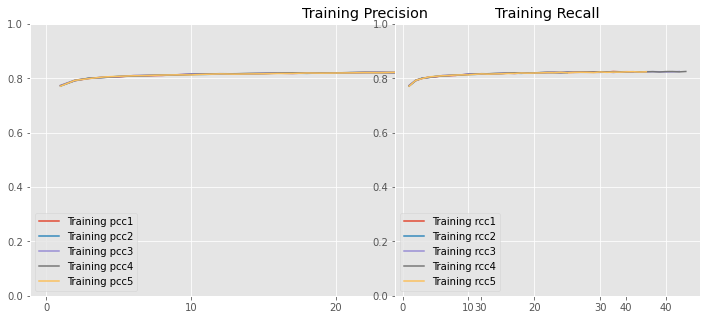

In [126]:
plot_history(history)

In [ ]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 200)         11000000  
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 256)         336896    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0  

In [ ]:
model.save('/content/drive/MyDrive/Capstone/model1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/model1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Capstone/model1/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/model1')

In [ ]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_18 (Embedding)     (None, None, 200)         11000000  
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 256)         336896    
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 64)                73984     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0  